In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_8.csv")

In [4]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["numVectors"] = dataFrame["numVectors"].astype(int)
dataFrame["vectorSize"] = dataFrame["vectorSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Vector sizes:", sorted(dataFrame["vectorSize"].unique()))
print("NumVectors:", sorted(dataFrame["numVectors"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)


Loaded rows: 280
Modes: ['sequential' 'sections']
Vector sizes: [100000, 300000]
NumVectors: [10, 50]
Thread counts: [1, 2, 4, 6, 8, 16, 32]


,testType,numVectors,vectorSize,numThreads,mode,timeSeconds,totalSum,runIndex,ompEnv
0,OpenMP_8,10,100000,1,sequential,0.009281,250103.701504,1,OMP_NUM_THREADS=1
1,OpenMP_8,10,100000,1,sequential,0.008024,250162.637416,2,OMP_NUM_THREADS=1
2,OpenMP_8,10,100000,1,sequential,0.008165,249792.182452,3,OMP_NUM_THREADS=1
3,OpenMP_8,10,100000,1,sequential,0.008668,249428.095347,4,OMP_NUM_THREADS=1
4,OpenMP_8,10,100000,1,sequential,0.009136,250316.521574,5,OMP_NUM_THREADS=1
5,OpenMP_8,10,100000,2,sequential,0.008604,250087.266624,1,OMP_NUM_THREADS=2
6,OpenMP_8,10,100000,2,sequential,0.008424,250123.413134,2,OMP_NUM_THREADS=2
7,OpenMP_8,10,100000,2,sequential,0.009921,249696.202163,3,OMP_NUM_THREADS=2


In [5]:
groupedFrame = dataFrame.groupby(["mode","numVectors","vectorSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","numVectors","vectorSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,numVectors,vectorSize,numThreads,median,mean,std,count
0,sections,10,100000,1,0.008618,0.008713,0.000239,5
1,sections,10,100000,2,0.087050,0.086882,0.000824,5
2,sections,10,100000,4,0.085965,0.086111,0.001150,5
3,sections,10,100000,6,0.070696,0.058849,0.027626,5
4,sections,10,100000,8,0.071422,0.073648,0.006017,5
5,sections,10,100000,16,0.071612,0.061795,0.031471,5
6,sections,10,100000,32,0.084379,0.067717,0.032401,5
7,sections,10,300000,1,0.013489,0.013808,0.000449,5
8,sections,10,300000,2,0.089788,0.092146,0.007383,5
9,sections,10,300000,4,0.083774,0.057671,0.038151,5


In [6]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["mode","numVectors","vectorSize"]
    for keys, subFrame in groupedDf.groupby(groupKeys):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        sf = subFrame.copy()
        sf["speedup"] = baseTime / sf["median"]
        sf["efficiency"] = sf["speedup"] / sf["numThreads"]
        frames.append(sf)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,numVectors,vectorSize,numThreads,median,mean,std,count,speedup,efficiency
0,sections,10,100000,1,0.008618,0.008713,0.000239,5,1.000000,1.000000
1,sections,10,100000,2,0.087050,0.086882,0.000824,5,0.099001,0.049500
2,sections,10,100000,4,0.085965,0.086111,0.001150,5,0.100250,0.025063
3,sections,10,100000,6,0.070696,0.058849,0.027626,5,0.121902,0.020317
4,sections,10,100000,8,0.071422,0.073648,0.006017,5,0.120663,0.015083
5,sections,10,100000,16,0.071612,0.061795,0.031471,5,0.120343,0.007521
6,sections,10,100000,32,0.084379,0.067717,0.032401,5,0.102134,0.003192
7,sections,10,300000,1,0.013489,0.013808,0.000449,5,1.000000,1.000000
8,sections,10,300000,2,0.089788,0.092146,0.007383,5,0.150232,0.075116
9,sections,10,300000,4,0.083774,0.057671,0.038151,5,0.161017,0.040254


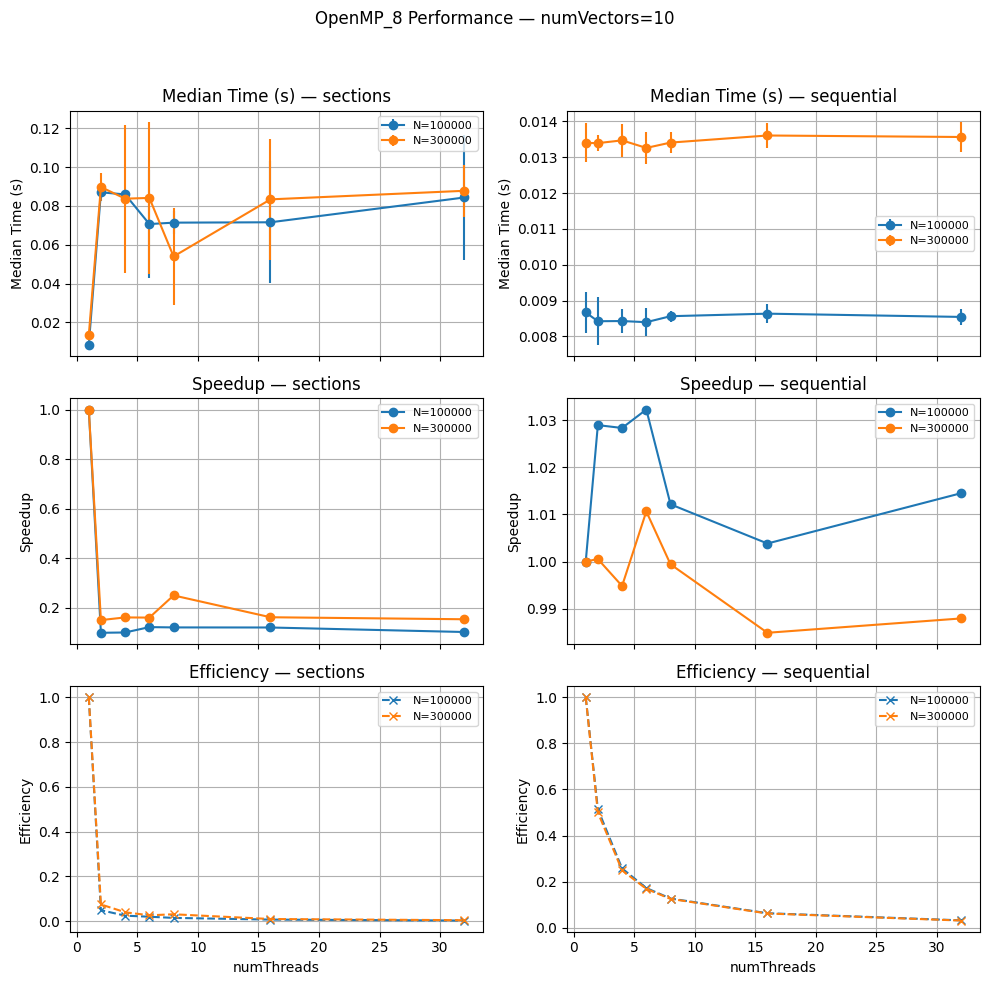

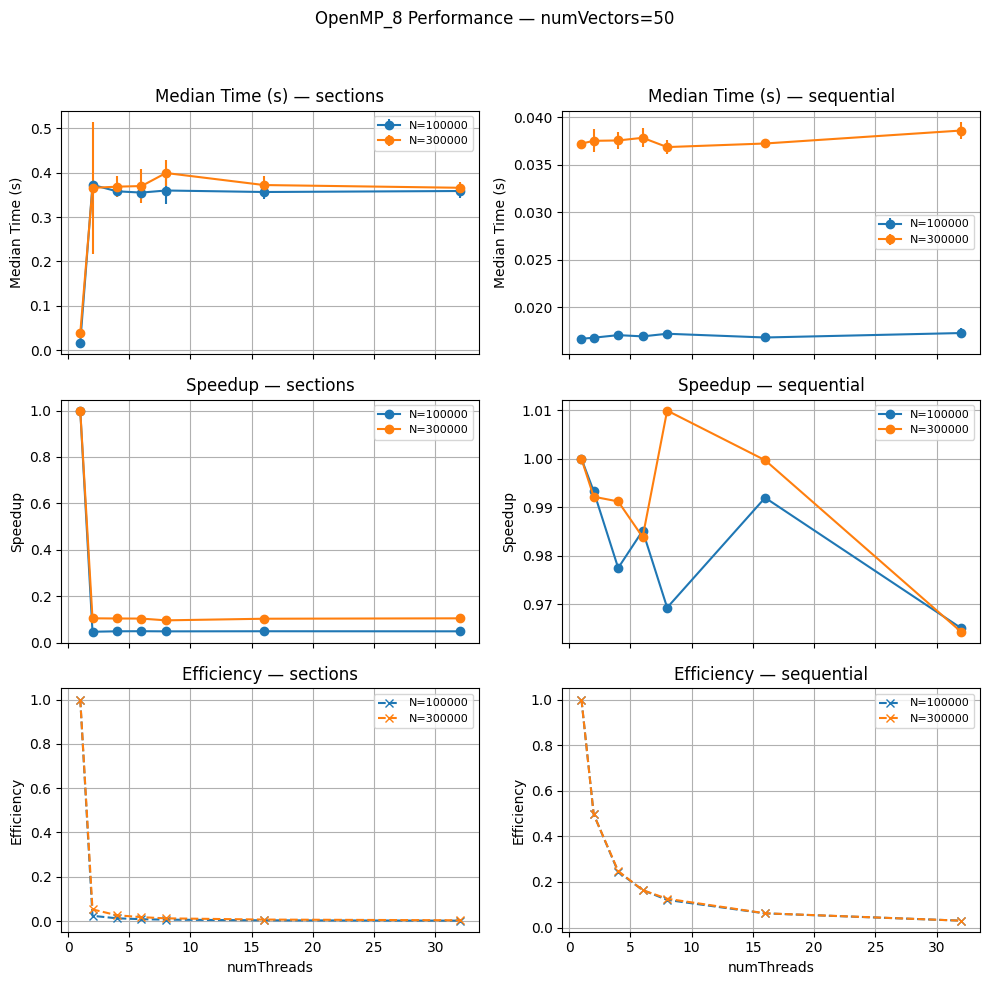

In [17]:
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

modes = sorted(perfFrame["mode"].unique())
vectorSizeList = sorted(perfFrame["vectorSize"].unique())
numVectorsList = sorted(perfFrame["numVectors"].unique())
numCols = max(1, len(modes))

for numVectorsVal in numVectorsList:
    filterByNumVectors = perfFrame[perfFrame["numVectors"] == numVectorsVal]
    if filterByNumVectors.empty:
        print(f"No data for numVectors={numVectorsVal}")
        continue

    fig, axes = plt.subplots(len(metrics), numCols, figsize=(5 * numCols, 10), sharex=True)
    if len(metrics) == 1 and numCols == 1:
        axes2d = np.array([[axes]])
    elif len(metrics) == 1:
        axes2d = np.array([axes])
    elif numCols == 1:
        axes2d = np.array([[ax] for ax in axes])
    else:
        axes2d = axes

    for colIdx, modeVal in enumerate(modes):
        for rowIdx, metric in enumerate(metrics):
            ax = axes2d[rowIdx][colIdx]
            subForMode = filterByNumVectors[filterByNumVectors["mode"] == modeVal]
            if subForMode.empty:
                ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                ax.set_title(f"{modeVal}")
                ax.grid(True)
                continue

            for vectorSizeVal in vectorSizeList:
                subFrame = subForMode[subForMode["vectorSize"] == vectorSizeVal].sort_values("numThreads")
                if subFrame.empty:
                    continue
                x = subFrame["numThreads"].values
                y = subFrame[metric].values
                if metric == "median":
                    yerr = subFrame["std"].values
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={vectorSizeVal}")
                else:
                    linestyle = '-' if metric == 'speedup' else '--'
                    markerStyle = 'o' if metric == 'speedup' else 'x'
                    ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={vectorSizeVal}")

            ax.set_title(f"{metricLabels[metric]} — {modeVal}")
            if rowIdx == len(metrics) - 1:
                ax.set_xlabel('numThreads')
            ax.set_ylabel(metricLabels[metric])
            ax.grid(True)
            ax.legend(fontsize=8)

    plt.suptitle(f'OpenMP_8 Performance — numVectors={numVectorsVal}')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [ ]:
for modeVal in perfFrame["mode"].unique():
    sample = perfFrame[perfFrame["mode"] == modeVal]
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(sample.pivot_table(index=["numThreads"], columns=["vectorSize","numVectors"], values="median"))
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(sample.pivot_table(index=["numThreads"], columns=["vectorSize","numVectors"], values="speedup"))



=== mode: sections — median time (s) ===


vectorSize    100000              300000          
numVectors        10        50        10        50
numThreads                                        
1           0.008618  0.017423  0.013489  0.038266
2           0.087050  0.372444  0.089788  0.365650
4           0.085965  0.357861  0.083774  0.368337
6           0.070696  0.355024  0.084162  0.369715
8           0.071422  0.359697  0.054000  0.399092
16          0.071612  0.356330  0.083419  0.371991
32          0.084379  0.358543  0.087829  0.365842


=== mode: sections — speedup ===


vectorSize    100000              300000          
numVectors        10        50        10        50
numThreads                                        
1           1.000000  1.000000  1.000000  1.000000
2           0.099001  0.046780  0.150232  0.104652
4           0.100250  0.048687  0.161017  0.103889
6           0.121902  0.049076  0.160274  0.103501
8           0.120663  0.048438  0.249796  0.095883
16          0.120343  0.048896  0.161702  0.102868
32          0.102134  0.048594  0.153583  0.104597


=== mode: sequential — median time (s) ===


vectorSize    100000              300000          
numVectors        10        50        10        50
numThreads                                        
1           0.008668  0.016693  0.013403  0.037224
2           0.008424  0.016805  0.013396  0.037517
4           0.008429  0.017077  0.013473  0.037554
6           0.008397  0.016944  0.013262  0.037834
8           0.008564  0.017221  0.013411  0.036858
16          0.008635  0.016828  0.013609  0.037235
32          0.008544  0.017296  0.013567  0.038599


=== mode: sequential — speedup ===


vectorSize    100000              300000          
numVectors        10        50        10        50
numThreads                                        
1           1.000000  1.000000  1.000000  1.000000
2           1.028965  0.993335  1.000523  0.992190
4           1.028354  0.977514  0.994804  0.991213
6           1.032273  0.985186  1.010632  0.983877
8           1.012144  0.969340  0.999403  1.009930
16          1.003822  0.991978  0.984863  0.999705
32          1.014513  0.965136  0.987912  0.964377

In [16]:
summaryRows = []
for (modeVal, numVectorsVal, vectorSizeVal), sub in perfFrame.groupby(["mode","numVectors","vectorSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "numVectors": numVectorsVal,
        "vectorSize": vectorSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","numVectors","vectorSize"])
display(summaryAnalysisFrame)


,mode,numVectors,vectorSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,sections,10,100000,1,1.000000,1.000000,0.008618
1,sections,10,300000,1,1.000000,1.000000,0.013489
2,sections,50,100000,1,1.000000,1.000000,0.017423
3,sections,50,300000,1,1.000000,1.000000,0.038266
4,sequential,10,100000,6,1.032273,0.172046,0.008668
5,sequential,10,300000,6,1.010632,0.168439,0.013403
6,sequential,50,100000,1,1.000000,1.000000,0.016693
7,sequential,50,300000,8,1.009930,0.126241,0.037224
